In [2]:
!unzip asian_Dataset_jewelry.zip

Archive:  asian_Dataset_jewelry.zip
   creating: CV_Dataset_1800/
   creating: CV_Dataset_1800/TEST_300/
   creating: CV_Dataset_1800/TEST_300/Anklets/
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-001.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-002.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-003.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-004.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-005.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-006.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-007.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-008.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-009.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-010.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-011.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-012.jpg  
  inflating: CV_Dataset_1800/TEST_300/Anklets/Anklets-013.jpg  
  inflating: CV_

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [31]:
DATA_DIR = "/content/CV_Dataset_1800"

IMG_SIZE = (300, 300)   # EfficientNetB3
BATCH_SIZE = 16
SEED = 42

TRAIN_DIR = "/content/CV_Dataset_1800/TRAIN_1500"
TEST_DIR  = "/content/CV_Dataset_1800/TEST_300"

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 1500 files belonging to 6 classes.
Using 1200 files for training.
Found 1500 files belonging to 6 classes.
Using 300 files for validation.
Found 300 files belonging to 6 classes.
Classes: ['Anklets', 'Bangles', 'Earring', 'Necklace', 'Ring', 'Tikka']


In [33]:
from tensorflow.keras.applications.efficientnet import preprocess_input

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, training=False):
    ds = ds.map(
        lambda x, y: (preprocess_input(x), tf.one_hot(y, depth=num_classes)),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        ds = ds.shuffle(1000)
    return ds.prefetch(AUTOTUNE)

In [34]:
train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [35]:
for images, labels in train_ds.take(1):
    print(labels.shape)

(16, 6)


In [36]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False


In [37]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs, training=True) # augment the dat
x = base_model(x, training=False) # pass the preprocessed input to the base model
x = layers.GlobalAveragePooling2D()(x) # flatten multidimensional feature map to feature vector
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# X is used in every equation above because it represents the input / output tensor of a layer
# for example, the data augmentation layer takes "inputs" as input and outputs "x", this "x" is input of base model and it outputs a new "x"

outputs = layers.Dense(num_classes, activation="softmax")(x)
# the above liness of code define a computatuonal graph which is basically the flow of data in layers.
model = models.Model(inputs, outputs) # this line creates the keras object of model which can be compile()d and trained (fit())


In [60]:
Loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
Epochs=15

In [67]:
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=3,
#     restore_best_weights=True
# )

In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=Loss,
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Epochs,
    # callbacks=[early_stop]
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.9969 - loss: 0.4653 - val_accuracy: 1.0000 - val_loss: 0.4324
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.9994 - loss: 0.4567 - val_accuracy: 1.0000 - val_loss: 0.4373
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.9982 - loss: 0.4589 - val_accuracy: 1.0000 - val_loss: 0.4384
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.9988 - loss: 0.4624 - val_accuracy: 1.0000 - val_loss: 0.4320
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.9993 - loss: 0.4557 - val_accuracy: 1.0000 - val_loss: 0.4305
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 1.0000 - loss: 0.4560 - val_accuracy: 1.0000 - val_loss: 0.4289
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 1.0000 - loss: 0.4537 - val_accuracy: 1.0000 - val_loss: 0.4318
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.9994 - loss: 0.4536 - val_accu

In [69]:
# early_stop_ft = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=3,
#     restore_best_weights=True
# )

In [70]:
base_model.trainable = True

# Freeze bottom layers, fine-tune top 20
for layer in base_model.layers[:-30]:
    layer.trainable = False
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=Loss,
    metrics=["accuracy"]
)
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Epochs,
    # callbacks=[early_stop_ft]
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 1.0000 - loss: 0.4481 - val_accuracy: 1.0000 - val_loss: 0.4278
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.9990 - loss: 0.4465 - val_accuracy: 1.0000 - val_loss: 0.4266
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9988 - loss: 0.4467 - val_accuracy: 1.0000 - val_loss: 0.4259
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 1.0000 - loss: 0.4417 - val_accuracy: 1.0000 - val_loss: 0.4257
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 1.0000 - loss: 0.4421 - val_accuracy: 1.0000 - val_loss: 0.4255
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 1.0000 - loss: 0.4435 - val_accuracy: 1.0000 - val_loss: 0.4251
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 1.0000 - loss: 0.4448 - val_accuracy: 1.0000 - val_loss: 0.4250
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.9994 - loss: 0.4437 - val_accu

In [71]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate(
    [np.argmax(y, axis=1) for x, y in test_ds],
    axis=0
)

y_pred = np.argmax(model.predict(test_ds), axis=1)


print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9274 - loss: 0.5733
Test accuracy: 0.9266666769981384
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step
[[48  0  0  2  0  0]
 [ 0 43  0  0  7  0]
 [ 0  0 50  0  0  0]
 [ 0  0  8 42  0  0]
 [ 0  0  0  0 50  0]
 [ 0  0  4  0  1 45]]
              precision    recall  f1-score   support

     Anklets       1.00      0.96      0.98        50
     Bangles       1.00      0.86      0.92        50
     Earring       0.81      1.00      0.89        50
    Necklace       0.95      0.84      0.89        50
        Ring       0.86      1.00      0.93        50
       Tikka       1.00      0.90      0.95        50

    accuracy                           0.93       300
   macro avg       0.94      0.93      0.93       300
weighted avg       0.94      0.93      0.93       300



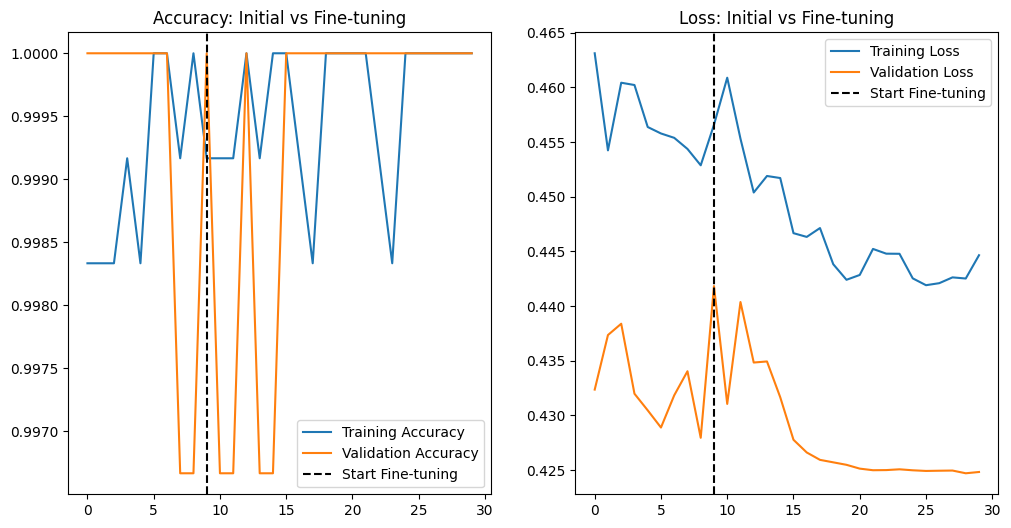

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_full_history(h1, h2, initial_epochs):
    # Extract metrics from both histories
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=initial_epochs-1, color='k', linestyle='--', label='Start Fine-tuning')
    plt.title('Accuracy: Initial vs Fine-tuning')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=initial_epochs-1, color='k', linestyle='--', label='Start Fine-tuning')
    plt.title('Loss: Initial vs Fine-tuning')
    plt.legend()

    plt.show()

# Use it by passing both histories and the count of first-run epochs
plot_full_history(history, history_finetune, initial_epochs=10)
